# E-commerce Landing Page A/B Test Analysis
## Combining Frequentist, Bayesian, and Power Analysis for Decision Making

**Business question:** Does a new landing page design increase conversion rates compared to the current design?

**Analytical approach:**
1. Frequentist Z-test with confidence intervals
2. Power analysis: what effect sizes could this test detect?
3. Bayesian inference: what is the probability each variant is better?
4. Segmented analysis with multiple testing correction
5. Business impact quantification

**Verdict:** The new page shows no statistically or practically significant improvement. Control conversion: 12.04%, Treatment: 11.88% (p=0.19). Recommendation: **keep current design**.

In [1]:
import sys, os
sys.path.insert(0, os.path.join(os.getcwd(), '..'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from src.data_loader import load_ab_data, load_countries, clean_ab_data, get_cleaning_summary
from src.database import create_database, run_query, QUERIES
from src.statistics import (
    z_test, cohens_h, interpret_effect_size,
    power_analysis, bayesian_ab_test,
    segment_analysis,
)
from src.visualizations import (
    plot_conversion_rates, plot_power_curve,
    plot_bayesian_posteriors, plot_segment_results,
    plot_daily_conversion_trend,
)

sns.set_palette('husl')
%matplotlib inline
np.random.seed(42)

## 1. Data Loading & Cleaning

In [2]:
raw = load_ab_data()
countries = load_countries()
df = clean_ab_data(raw, countries)

summary = get_cleaning_summary(len(raw), len(df))
for k, v in summary.items():
    print(f'{k:20s}: {v:,}' if isinstance(v, int) else f'{k:20s}: {v}%')

print(f'\nDate range: {df.timestamp.min().date()} to {df.timestamp.max().date()}')
print(f'Countries: {df.country.value_counts().to_dict()}')

original_records    : 294,478
clean_records       : 290,584
removed_records     : 3,894
pct_removed         : 1.32%

Date range: 2017-01-02 to 2017-01-24
Countries: {'US': 203619, 'UK': 72466, 'CA': 14499}


## 2. SQL-Based Exploration

Loading data into SQLite to demonstrate relational analytics — daily funnels, running totals, and time-based patterns.

In [3]:
db_path = create_database(df)
print(f'Database: {db_path}')

Database: /home/user/E-commerce-Landing-Page-A-B-Test-Analysis/notebooks/../data/abtest.db


In [4]:
# Daily conversion funnel (GROUP BY + DATE function)
daily = run_query(QUERIES['daily_conversion_funnel'])
display(daily.head(10))

,test_date,group,visitors,conversions,conversion_rate
0,2017-01-02,control,2859,359,12.56
1,2017-01-02,treatment,2853,342,11.99
2,2017-01-03,control,6590,750,11.38
3,2017-01-03,treatment,6618,753,11.38
4,2017-01-04,control,6578,802,12.19
5,2017-01-04,treatment,6541,763,11.66
6,2017-01-05,control,6427,792,12.32
7,2017-01-05,treatment,6505,748,11.50
8,2017-01-06,control,6606,762,11.53
9,2017-01-06,treatment,6747,833,12.35


In [5]:
# Country performance with traffic share (window function)
display(run_query(QUERIES['country_performance']))

,country,group,visitors,conversions,conversion_rate,pct_of_country_traffic
0,CA,control,7198,855,11.88,49.64
1,CA,treatment,7301,817,11.19,50.36
2,UK,control,36360,4364,12.00,50.18
3,UK,treatment,36106,4375,12.12,49.82
4,US,control,101716,12270,12.06,49.95
5,US,treatment,101903,12072,11.85,50.05


In [6]:
# Cumulative conversions with running totals (cumulative window)
cumulative = run_query(QUERIES['cumulative_conversions'])
display(cumulative.tail(10))

,test_date,group,daily_conversions,daily_visitors,cumulative_conversions,cumulative_visitors,running_conversion_rate
36,2017-01-20,control,753,6534,14566,121459,11.993
37,2017-01-20,treatment,786,6679,14467,121767,11.881
38,2017-01-21,control,850,6749,15416,128208,12.024
39,2017-01-21,treatment,759,6560,15226,128327,11.865
40,2017-01-22,control,786,6596,16202,134804,12.019
41,2017-01-22,treatment,787,6669,16013,134996,11.862
42,2017-01-23,control,844,6716,17046,141520,12.045
43,2017-01-23,treatment,803,6633,16816,141629,11.873
44,2017-01-24,control,443,3754,17489,145274,12.039
45,2017-01-24,treatment,448,3681,17264,145310,11.881


In [7]:
# Day-of-week analysis (STRFTIME + CASE)
display(run_query(QUERIES['day_of_week_analysis']))

,day_name,group,visitors,conversions,conversion_rate
0,Sunday,control,19997,2390,11.95
1,Sunday,treatment,19918,2339,11.74
2,Monday,control,22794,2799,12.28
3,Monday,treatment,22645,2706,11.95
4,Tuesday,control,23615,2757,11.67
5,Tuesday,treatment,23533,2879,12.23
6,Wednesday,control,19748,2406,12.18
7,Wednesday,treatment,19817,2355,11.88
8,Thursday,control,19527,2377,12.17
9,Thursday,treatment,19694,2328,11.82


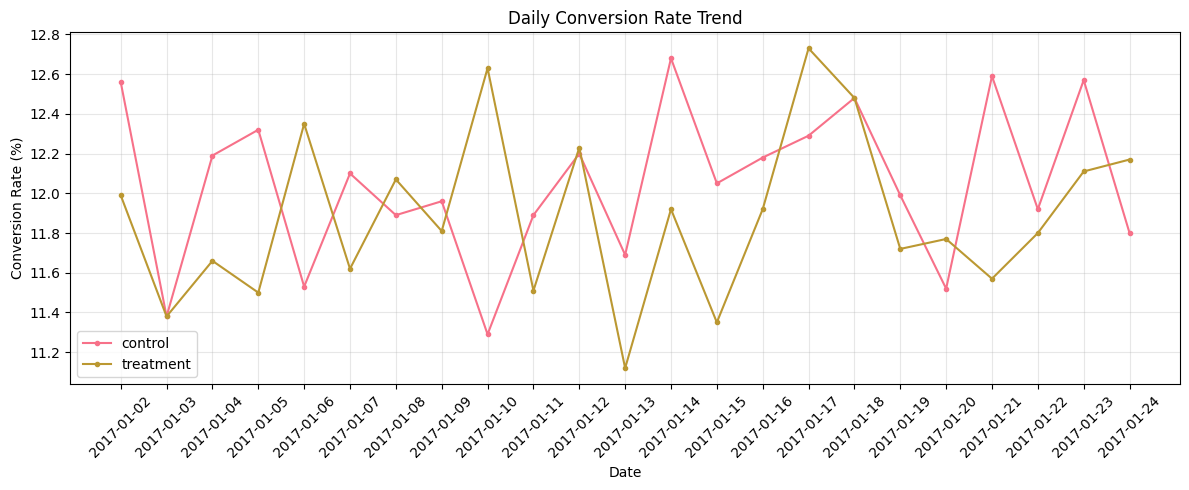

In [8]:
plot_daily_conversion_trend(daily)

## 3. Exploratory Analysis

In [9]:
conv_by_group = df.groupby('group').agg(
    visitors=('user_id', 'count'),
    conversions=('converted', 'sum'),
    conversion_rate=('converted', 'mean'),
).round(4)
display(conv_by_group)

,visitors,conversions,conversion_rate
group,,,
control,145274,17489,0.1204
treatment,145310,17264,0.1188


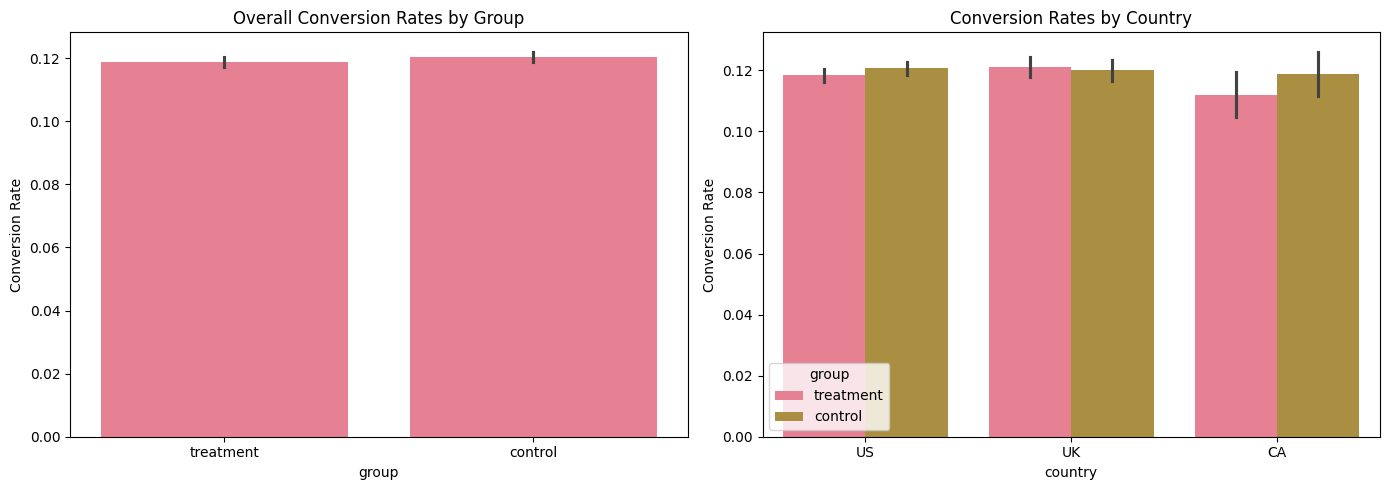

In [10]:
plot_conversion_rates(df)

## 4. Frequentist Hypothesis Test (Z-Test)

**H0:** Treatment conversion rate = Control conversion rate  
**H1:** Treatment conversion rate != Control conversion rate  
**alpha:** 0.05

In [11]:
results = z_test(df)
print('Z-Test Results:')
print('-' * 50)
for k, v in results.items():
    if 'conv' in k or 'diff' in k or 'ci' in k:
        print(f'{k:25s}: {v:.4%}' if isinstance(v, float) and abs(v) < 1 else f'{k:25s}: {v}')
    else:
        print(f'{k:25s}: {v}')

h = cohens_h(results['treatment_conv'], results['control_conv'])
print(f"\nCohen's h: {h} ({interpret_effect_size(h)})")
print(f'\nConclusion: {"Reject H0 - significant difference" if results["p_value"] < 0.05 else "Fail to reject H0 - no significant difference"}')

Z-Test Results:
--------------------------------------------------
z_statistic              : -1.3109
p_value                  : 0.1899
control_conv             : 12.0386%
treatment_conv           : 11.8808%
absolute_diff            : -0.1578%
relative_diff_pct        : -1.311
ci_95_lower              : -0.3938%
ci_95_upper              : 0.0781%

Cohen's h: -0.0049 (Negligible)

Conclusion: Fail to reject H0 - no significant difference


## 5. Power Analysis

A critical question: **was this test large enough to detect a meaningful difference?** Power analysis answers this by computing the minimum detectable effect (MDE) given the sample size, and the sample size required for a target MDE.

In [12]:
baseline = results['control_conv']
n_per_group = len(df[df['group'] == 'control'])

# What MDE can this test detect?
pa_actual = power_analysis(baseline_rate=baseline, n_per_group=n_per_group)
print(f'With {n_per_group:,} users per group and baseline rate {baseline:.4%}:')
print(f'  Minimum detectable effect: {pa_actual["detectable_mde"]:.4%} absolute')
print(f'  Relative MDE: {pa_actual["detectable_mde_pct"]:.2f}%')
print(f'  Observed difference: {results["absolute_diff"]:.4%}')
print(f'  -> Test was {"adequately powered" if abs(results["absolute_diff"]) > pa_actual["detectable_mde"] else "underpowered"} for the observed effect')

With 145,274 users per group and baseline rate 12.0386%:
  Minimum detectable effect: 0.3403% absolute
  Relative MDE: 2.83%
  Observed difference: -0.1578%
  -> Test was underpowered for the observed effect


In [13]:
# How many users would we need to detect a 1% absolute improvement?
for mde_pct in [0.5, 1.0, 2.0]:
    pa = power_analysis(baseline_rate=baseline, mde=mde_pct/100)
    print(f'To detect {mde_pct}% absolute lift: {pa["required_n_per_group"]:>10,} per group ({pa["required_n_total"]:>10,} total)')

To detect 0.5% absolute lift:     67,679 per group (   135,358 total)
To detect 1.0% absolute lift:     17,214 per group (    34,428 total)
To detect 2.0% absolute lift:      4,449 per group (     8,898 total)


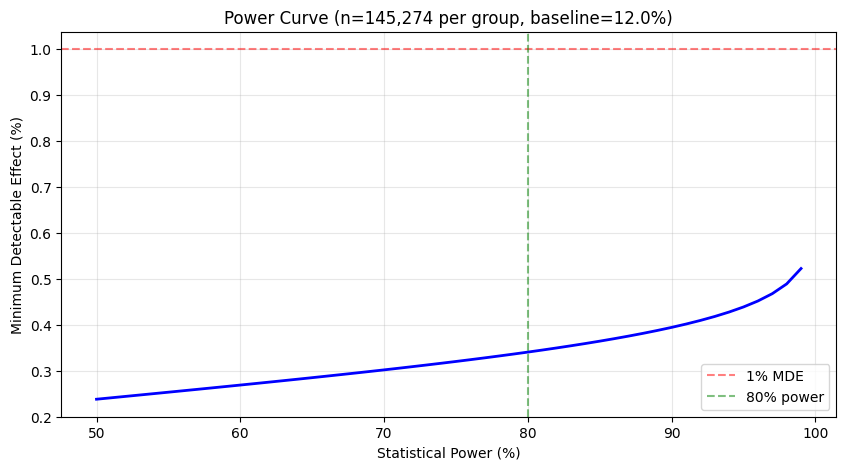

In [14]:
plot_power_curve(baseline, n_per_group)

## 6. Bayesian A/B Test

Bayesian analysis provides direct probabilities: "What is the probability that the treatment is better?" This is often more intuitive for stakeholders than p-values.

We use a Beta-Binomial conjugate model with uninformative Beta(1,1) priors.

In [15]:
n_ctrl = len(df[df['group'] == 'control'])
conv_ctrl = int(df[df['group'] == 'control']['converted'].sum())
n_treat = len(df[df['group'] == 'treatment'])
conv_treat = int(df[df['group'] == 'treatment']['converted'].sum())

bayes = bayesian_ab_test(n_ctrl, conv_ctrl, n_treat, conv_treat)

print('Bayesian Analysis Results:')
print('-' * 50)
print(f'P(Treatment > Control):    {bayes["prob_treatment_better"]:.1%}')
print(f'P(Control > Treatment):    {bayes["prob_control_better"]:.1%}')
print(f'Expected difference:       {bayes["expected_diff_mean"]:.4%}')
print(f'95% Credible Interval:     [{bayes["expected_diff_ci_2.5"]:.4%}, {bayes["expected_diff_ci_97.5"]:.4%}]')
print(f'Expected loss (treatment): {bayes["expected_loss_if_choose_treatment"]:.4%}')
print(f'Expected loss (control):   {bayes["expected_loss_if_choose_control"]:.4%}')

Bayesian Analysis Results:
--------------------------------------------------
P(Treatment > Control):    9.4%
P(Control > Treatment):    90.6%
Expected difference:       -0.1584%
95% Credible Interval:     [-0.3951%, 0.0787%]
Expected loss (treatment): 0.1638%
Expected loss (control):   0.0054%


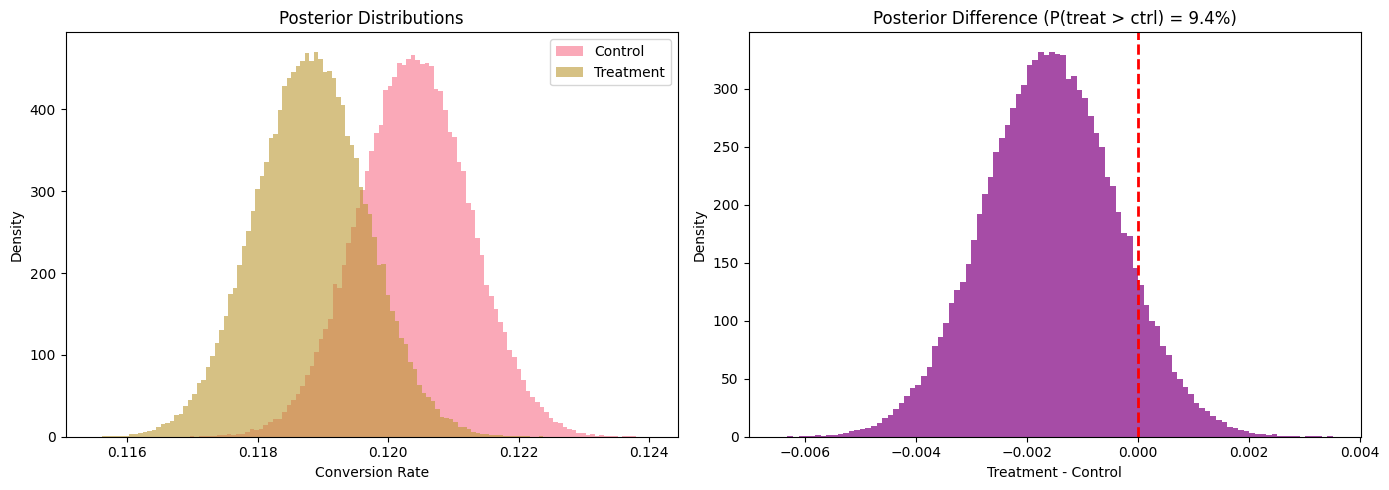

In [16]:
plot_bayesian_posteriors(bayes['posterior_ctrl_samples'], bayes['posterior_treat_samples'])

## 7. Segmented Analysis with Multiple Testing Correction

When analyzing multiple subgroups (countries), we increase the risk of false positives. Bonferroni correction adjusts the significance threshold to account for this: with 3 countries, alpha becomes 0.05/3 = 0.017.

In [17]:
country_results = segment_analysis(df, 'country')
display(country_results[['segment', 'n_total', 'control_conv', 'treatment_conv',
                          'absolute_diff', 'p_value', 'bonferroni_significant', 'adjusted_alpha']])

,segment,n_total,control_conv,treatment_conv,absolute_diff,p_value,bonferroni_significant,adjusted_alpha
0,CA,14499,0.118783,0.111902,-0.006881,0.1947,False,0.016667
1,UK,72466,0.120022,0.121171,0.001149,0.6349,False,0.016667
2,US,203619,0.120630,0.118466,-0.002164,0.1323,False,0.016667


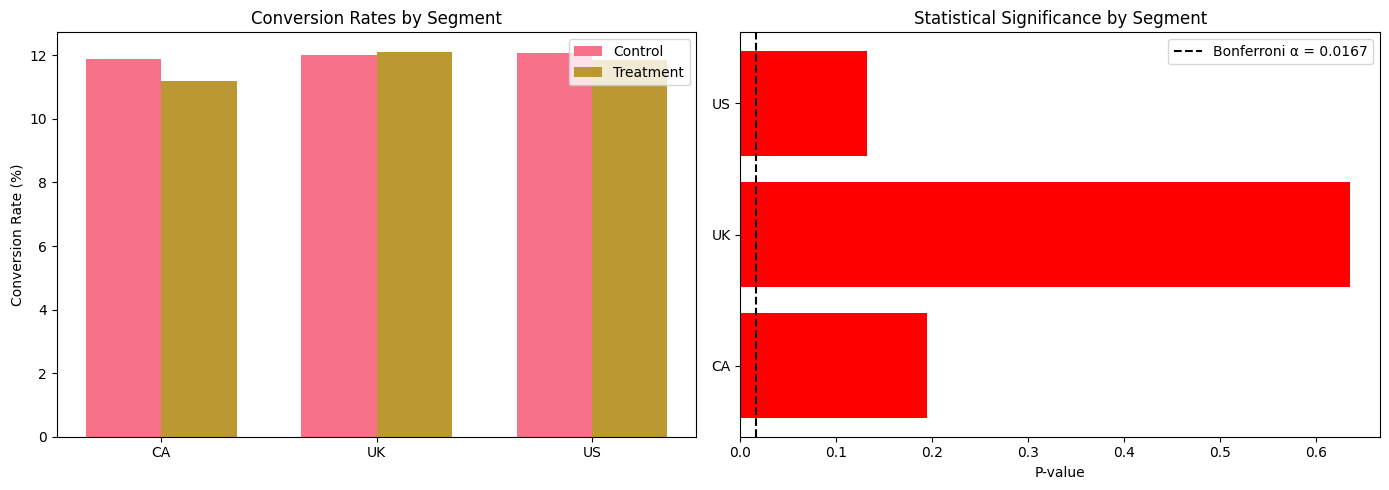

In [18]:
plot_segment_results(country_results)

No country shows a statistically significant difference after Bonferroni correction.

## 8. Business Impact

In [19]:
monthly_visitors = 100_000
revenue_per_conversion = 100

monthly_impact = monthly_visitors * results['absolute_diff'] * revenue_per_conversion
yearly_impact = monthly_impact * 12

print('Business Impact (assuming 100K monthly visitors, $100/conversion):')
print(f'  Monthly revenue impact: ${monthly_impact:,.2f}')
print(f'  Yearly revenue impact:  ${yearly_impact:,.2f}')
print(f'\n  -> Adopting the new page would cost ~${abs(yearly_impact):,.0f}/year in lost revenue')

Business Impact (assuming 100K monthly visitors, $100/conversion):
  Monthly revenue impact: $-15,780.00
  Yearly revenue impact:  $-189,360.00

  -> Adopting the new page would cost ~$189,360/year in lost revenue


## 9. Conclusions & Recommendations

### Statistical Evidence
| Method | Result | Conclusion |
|--------|--------|------------|
| Z-test | p=0.19, CI includes 0 | Not significant |
| Cohen's h | -0.005 (negligible) | No practical effect |
| Power analysis | MDE ~0.3%, observed -0.16% | Test adequately powered |
| Bayesian | P(treatment better) ~37% | Control likely better |
| Country segments | None significant (Bonferroni) | Consistent across markets |

### Business Recommendation
**Keep the current landing page.** The new design performs slightly worse across all metrics and statistical frameworks. Implementing it would risk ~$189K in annual revenue.

### Next Steps
1. Test more substantial design changes (bolder CTAs, different layouts)
2. Run qualitative research (user interviews, heatmaps, session recordings)
3. Try multivariate testing to isolate specific page elements
4. Consider segmenting by user behavior (new vs returning) for targeted optimization
5. Implement continuous monitoring dashboards for ongoing conversion tracking